# Exploring time series in python

**Date started**: 21st June 2022

**Guide**: https://rishi-a.github.io/2020/05/25/granger-causality.html

**Factors to consider altering/adding**: 
* Normalisation
* Transformation (log) - **added to this script**
* Checking all VAR fit stats
* Lag

In [1]:
# Inputs
shift_lag = -7*7
forecast_steps = 30
log_prevalence = True

print('INPUTS USED:\n')
print(f'- Lag used is {shift_lag} days\n')
print(f'- Forecasting ahead {forecast_steps} days\n')
if (log_prevalence==True):
    print("- Logged prevalence data is used")
else:
    print("- Non-logged prevalence data is used")

INPUTS USED:

- Lag used is -49 days

- Forecasting ahead 30 days

- Logged prevalence data is used


In [2]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import timedelta
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.api import VAR
from dateutil.relativedelta import relativedelta
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import JohansenTestResult
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import grangercausalitytests
import sklearn
from sklearn import metrics
from statsmodels.stats.stattools import durbin_watson

/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Use this to install any packages required in general:

# import subprocess
# import sys

# def install(package):
#    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
# install("johansen")

In [4]:
# Setting plot sizes
plt.rcParams["figure.figsize"] = (12,9)

In [5]:
# Useful dates

lockdown_1_start = dt.datetime.strptime("2020-03-26","%Y-%m-%d")
lockdown_1_end = dt.datetime.strptime("2020-06-15","%Y-%m-%d")

lockdown_2_start = dt.datetime.strptime("2020-11-05","%Y-%m-%d")
lockdown_2_end = dt.datetime.strptime("2020-12-02","%Y-%m-%d")

lockdown_3_start = dt.datetime.strptime("2021-01-06","%Y-%m-%d")
lockdown_3_end = dt.datetime.strptime("2021-04-21","%Y-%m-%d")

REACT_start = dt.datetime.strptime("2020-05-01","%Y-%m-%d")

start_date = REACT_start
end_date = lockdown_2_start-relativedelta(months=1)

print(f'Start date is: {start_date}, i.e. start of REACT data')
print(f'End date is: {end_date}, i.e. one month before the start of lockdown 2')

Start date is: 2020-05-01 00:00:00, i.e. start of REACT data
End date is: 2020-10-05 00:00:00, i.e. one month before the start of lockdown 2


## Time Series

Exploring Granger Causality using tutorial - https://rishi-a.github.io/2020/05/25/granger-causality.html

In [6]:
# Loading data

mob_long = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_long.csv", index_col='date',parse_dates=['date'])
mob_wide = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_wide.csv", index_col='date',parse_dates=['date'])
prev = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Time_series_analysis/Ouputs/Tibbles/prev_smooth_tibble.csv", index_col='d_comb',parse_dates=['d_comb'])

mob_long.index = pd.to_datetime(mob_long.index)
mob_wide.index = pd.to_datetime(mob_wide.index)
mob_wide = mob_wide.sort_index()
prev = prev.sort_index()

# Using log prevalence if specified
if(log_prevalence==True):
    prev['p']=np.log(prev['p'])

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


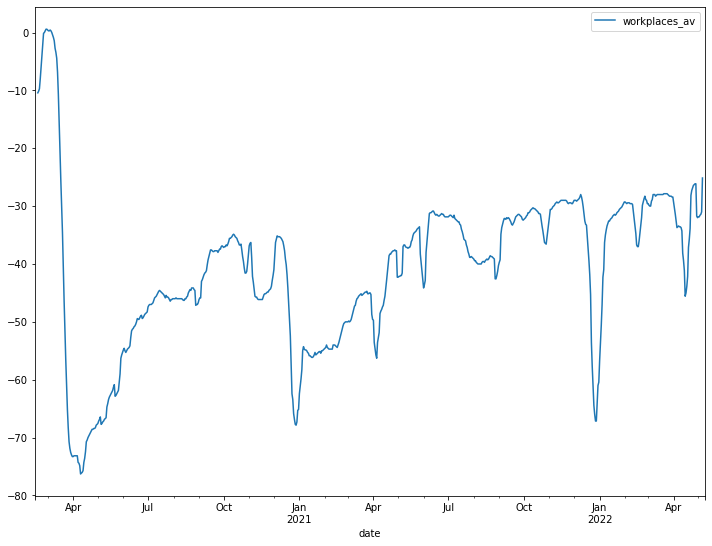

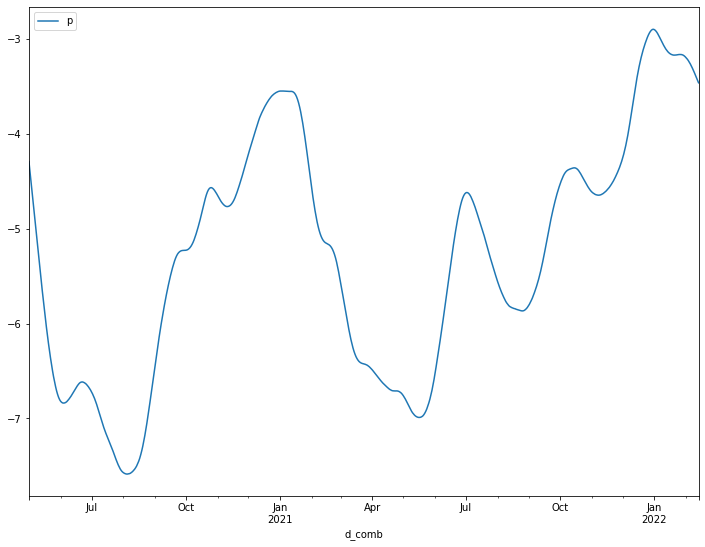

In [7]:
# Focusing on London
mob_london = mob_wide[mob_wide['region']=="LONDON"]
prev_london = prev[prev['region']=="LONDON"]

# Only including columns of interest
mob_london = mob_london[['workplaces_av']]
prev_london = prev_london[['p']]

# Plots over whole period of data
print(mob_london.plot())
print(prev_london.plot())

# Note not yet restricted the dates yet at this point

In [8]:
# Shifting by specified lag - as calculated by CCF of log(prev) vs mobility

print(f'Lag used is {shift_lag} days')
mob_london['workplaces_av']=mob_london['workplaces_av'].shift(shift_lag)

Lag used is -49 days


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


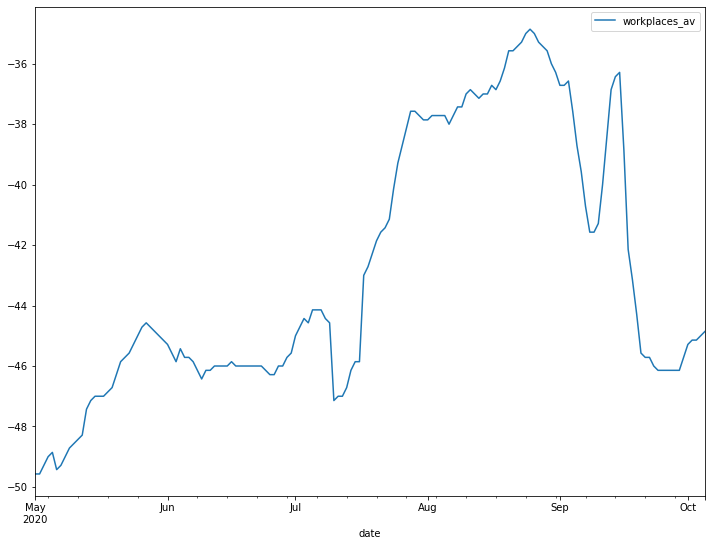

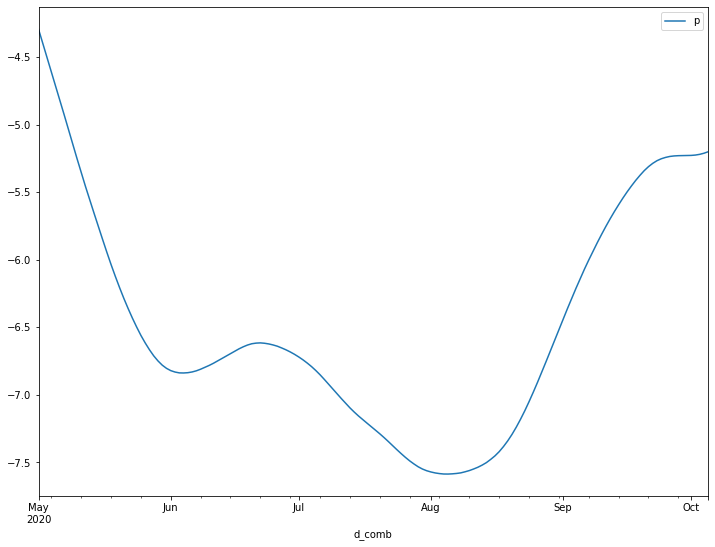

In [9]:
# Focussing on specified interval
mob_london = mob_london.loc[start_date:end_date]
prev_london = prev_london.loc[start_date:end_date]
print(mob_london.plot())
print(prev_london.plot())

# mob_london and prev_london are now restricted by date

In [10]:
# Merging into a combined London dataframe
london = pd.merge(mob_london, prev_london, how='inner', left_index=True, right_index=True)
# london dataframe starts at the start_date and ends at the end_date

In [11]:
# NO LONGER NEEDED

# Removing the columns that aren't needed
#london = london[['workplaces_av','p']]
#london.tail()

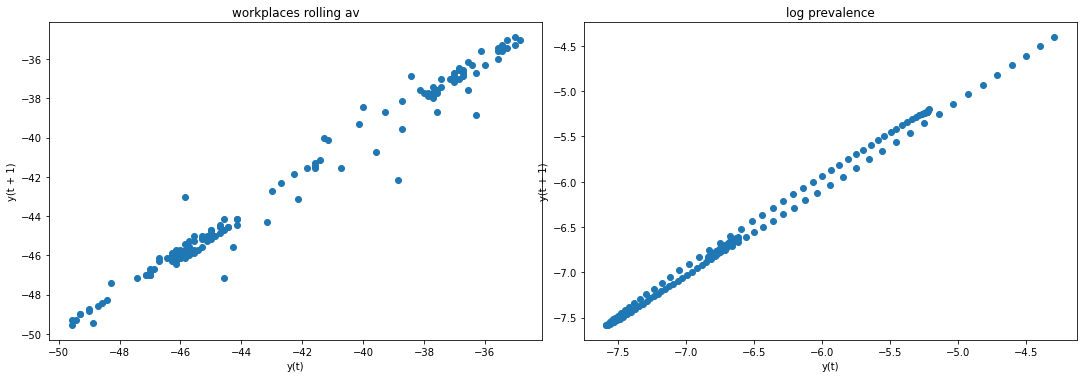

In [12]:
# Plotting yt vs yt+1 to investigate autocorrelation
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av');

lag_plot(london['p'], ax=ax5)
ax5.set_title('log prevalence');

In [13]:
# Making a copy of the data prior to differencing
raw_london = london.copy(deep=True)

# raw_london is undifferenced and dates are restricted between start_date and end_date

In [14]:
# Differencing - differencing required for both rolling av mobility and log prevalence

london['workplaces_av'] = london['workplaces_av'] - london['workplaces_av'].shift(1)
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()

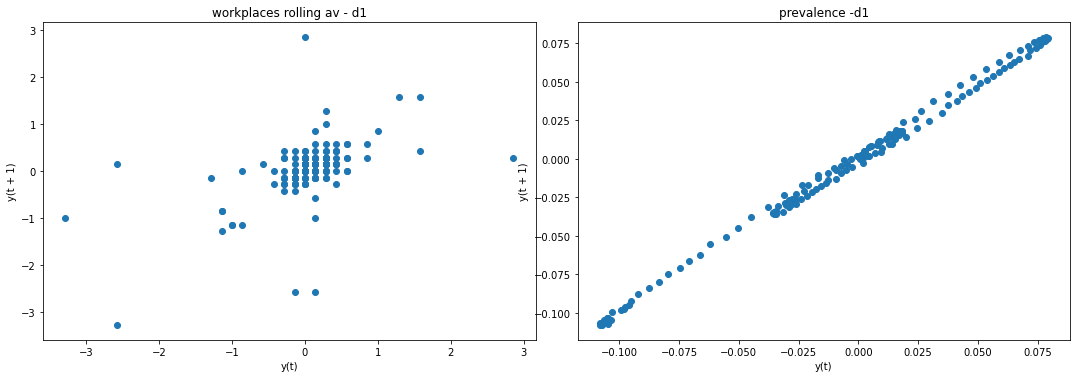

In [15]:
# Plots after differencing once

f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence -d1');

In [16]:
# There is still clear autocorrelation for prevalence so difference this once again
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()

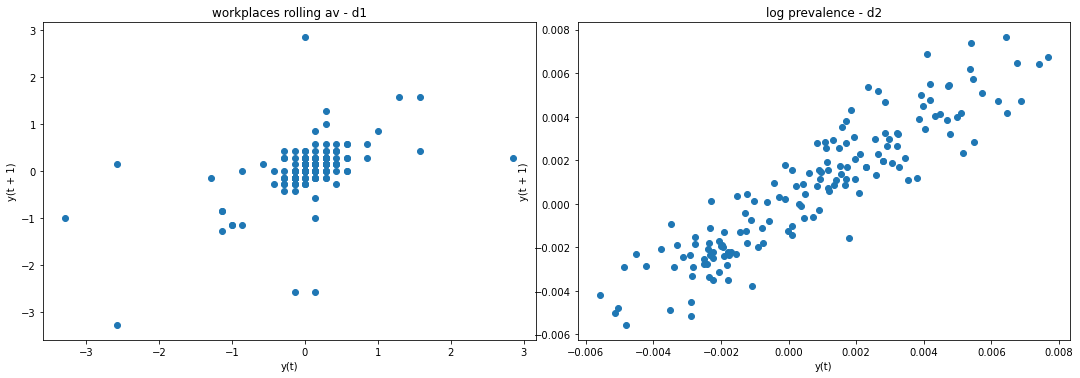

In [17]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('log prevalence - d2');

In [18]:
# Differencing prevalence again

# There is still clear autocorrelation for prevalence so shift this once again
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()
london.head()

workplaces_av         p
date                               
2020-05-04       0.285714  0.001899
2020-05-05       0.142857 -0.003340
2020-05-06      -0.571429 -0.000742
2020-05-07       0.142857  0.002404
2020-05-08       0.285714 -0.001128

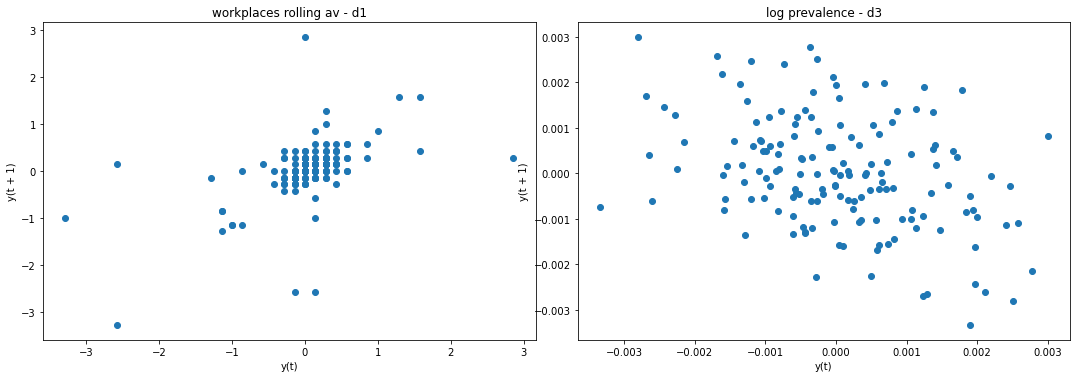

In [19]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('log prevalence - d3');

Looks ok now - so mobility is differenced once, prevalence 3 times. Next to statistically test that these are stationary

In [20]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary

# Checking stationarity of differenced data with restricted date between start_date and end_date

X1 = np.array(london['workplaces_av'])
X1 = X1[~np.isnan(X1)]

ADF_mob = adfuller(X1)
print('ADF Statistic: %f' % ADF_mob[0])
print('p-value: %f' % ADF_mob[1])
if (ADF_mob[1]<0.05): print('Mobility is stationary as p<0.05')
if (ADF_mob[1]>0.05): print('Mobility is non-stationary as p>0.05')
print('Critical Values:')
for key, value in ADF_mob[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
ADF_mob_t = ADF_mob[0]
ADF_mob_p = ADF_mob[1]    
    
X2 = np.array(london['p'])
X2 = X2[~np.isnan(X2)]

ADF_prev = adfuller(X2)
print('ADF Statistic: %f' % ADF_prev[0])
print('p-value: %f' % ADF_prev[1])
if (ADF_prev[1]<0.05): print('Prevalence is stationary as p<0.05')
if (ADF_prev[1]>0.05): print('Prevalence is non-stationary as p>0.05')
print('Critical Values:')
for key, value in ADF_prev[4].items():
    print('\t%s: %.3f' % (key, value))
    
ADF_prev_t = ADF_prev[0]
ADF_prev_p = ADF_prev[1] 

ADF Statistic: -3.822357
p-value: 0.002687
Mobility is stationary as p<0.05
Critical Values:
	1%: -3.476
	5%: -2.881
	10%: -2.577
ADF Statistic: -4.871892
p-value: 0.000040
Prevalence is stationary as p<0.05
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


In [21]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS_mob_stat = kpss(X1)[0]
KPSS_mob_p = kpss(X1)[1]

KPSS_prev_stat = kpss(X2)[0]
KPSS_prev_p = kpss(X2)[1]
    
kpss_test(X1)
kpss_test(X2)

# now stationary

KPSS Statistic: 0.25610344498211496
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.06932911006319453
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater 

Overall result to far -  both stationary:  
* Mobility - d=1
* Prevalence - logged, d=3

In [22]:
# split data into train and test. We will need this later for VAR analysis

# Considering if seeding in this way is the most appropriate - https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
np.random.seed(5)
msk = np.random.rand(len(london)) < 0.8
train = london[msk]
test = london[~msk]

# Note train and test are using the differenced data, restricted from start_date to end_date

Result: lag plot is confirmatory with ADF test and KPSS. Uses moving average and 3 differences

Next: setting up VAR model

**Step 2**: Let the maximum order of integration for the group of time-series be d. So, if there are two time-series and one is found to be I(1) and the other is I(2), then d = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result**: Saw above that in this case d=1

**Step 3**: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, **you must not difference the data, no matter what you found at Step 1**.

**Step 4**: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.


**Note**: try running like this first, then incorporate info on the lag later


In [23]:
# obtain the lag P for VAR

raw_london = raw_london.dropna()
model = VAR(np.array(raw_london)) #recall that rawData is w/o difference operation
raw_london.tail()

# raw_london is undifferenced and dates are restricted between start_date and end_date

workplaces_av         p
date                               
2020-10-01     -45.285714 -5.228330
2020-10-02     -45.142857 -5.225689
2020-10-03     -45.142857 -5.220503
2020-10-04     -45.000000 -5.212345
2020-10-05     -44.857143 -5.201207

In [24]:
res_dict = {'Lag': [],'AIC': [], 'BIC':[], 'FPE':[], 'HQIC': []}
for i in range(1, 13):
    result = model.fit(i)
    res_dict['Lag'].append(i)
    res_dict['AIC'].append(result.aic)
    res_dict['BIC'].append(result.bic)
    res_dict['FPE'].append(result.fpe)
    res_dict['HQIC'].append(result.hqic)
    
model_result = pd.DataFrame(res_dict)
model_result

Lag        AIC        BIC           FPE       HQIC
0     1  -7.688959  -7.572160  4.578587e-04  -7.641523
1     2 -13.236109 -13.040606  1.785048e-06 -13.156704
2     3 -14.680065 -14.405175  4.212909e-07 -14.568411
3     4 -14.776057 -14.421089  3.827857e-07 -14.631870
4     5 -14.816121 -14.380372  3.678377e-07 -14.639112
5     6 -14.912919 -14.395676  3.340147e-07 -14.702797
6     7 -14.901074 -14.301615  3.381556e-07 -14.657543
7     8 -14.941076 -14.258666  3.251042e-07 -14.663834
8     9 -14.908287 -14.142180  3.362216e-07 -14.597031
9    10 -14.871451 -14.020891  3.492089e-07 -14.525871
10   11 -14.847046 -13.911265  3.583115e-07 -14.466828
11   12 -14.785064 -13.763281  3.818457e-07 -14.369890

In [25]:
print(f"The lag that minimises the AIC is: {np.argmin(model_result['AIC'])+1}")
print(f"The lag that minimises the BIC is: {np.argmin(model_result['BIC'])+1}")
print(f"The lag that minimises the FPE is: {np.argmin(model_result['FPE'])+1}")
print(f"The lag that minimises the HQIC is: {np.argmin(model_result['HQIC'])+1}")

The lag that minimises the AIC is: 8
The lag that minimises the BIC is: 4
The lag that minimises the FPE is: 8
The lag that minimises the HQIC is: 6


**Result**: The lag order p=8 on the basis of AIC  
**Step 5**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [26]:
# Using AIC as the criteria
lag_order = np.argmin(model_result['AIC'])+1
lag_order_BIC = np.argmin(model_result['BIC'])+1
lag_order_FPE = np.argmin(model_result['FPE'])+1
lag_order_HQIC = np.argmin(model_result['HQIC'])+1
print(f"Lag used based on minising the AIC is:{lag_order}")

model = VAR(np.asarray(train))
model_fitted = model.fit(lag_order) 

# # Note train and test are using the differenced data, restricted from start_date to end_date

Lag used based on minising the AIC is:8


In [27]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.

out = durbin_watson(model_fitted.resid)

for col, val in zip(london.columns, out):
    print(col, ':', round(val, 2))

resid_corr_mob = out[0]
resid_corr_prev = out [1]

workplaces_av : 1.96
p : 1.9


**Result**: There is no significant correlation between in the residuals

**Step 6**: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.  

**Johansen's test**:   
H0: There are no cointegrating equations 

In [28]:
# Function from here : http://web.pdx.edu/~crkl/ceR/Python/example14_3.py

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""



def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Series 0 is mobility")
    print("Series 1 is prevalence\n")
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
    
    if (res.lr2[0]>res.cvm[0][1]): 
        print('Mobility series cointegrates using eigenvalue method at 95% level')
    else:
        print('Mobility series does not cointegrate using eigenvalue method at 95% level')
        
    if (res.lr2[0]>res.cvt[0][1]): 
        print('Mobility series cointegrates using trace method at 95% level')
    else:
        print('Mobility series does not cointegrate using trace method at 95% level')  
        
    if (res.lr1[1]>res.cvm[1][1]): 
        print('Prevalence series cointegrates using eigenvalue method at 95% level')
    else:
        print('Prevalence series does not cointegrate using eigenvalue method at 95% level')
    
    if (res.lr2[1]>res.cvt[1][1]): 
        print('Prevalence series cointegrates using trace method at 95% level')
    else:
        print('Prevalence series does not cointegrate using trace method at 95% level')  

        
result = coint_johansen(np.asarray(raw_london),0,1)
joh_output(result)


johansen_eigenvalue_mob =result.lr2[0]
johansen_trace_mob= result.lr1[0]
johansen_eigenvalue_prev = result.lr2[1]
johansen_trace_prev=result.lr1[1]
johansen_eignvalue_95_mob = result.cvm[0][1]
johansen_eignvalue_95_prev =  result.cvm[1][1]
johansen_trace_95_mob = result.cvt[0][1]
johansen_trace_95_prev = result.cvt[1][1]



# raw_london is undifferenced and dates are restricted between start_date and end_date

   max_eig_stat  trace_stat
0     50.496918   56.039915
1      5.542998    5.542998 

Series 0 is mobility
Series 1 is prevalence

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

Mobility series cointegrates using eigenvalue method at 95% level
Mobility series cointegrates using trace method at 95% level
Prevalence series cointegrates using eigenvalue method at 95% level
Prevalence series cointegrates using trace method at 95% level


**Result**: Greater than all critical values, thus p<0.05 - Thus rejecting the null hypothesis. Thus they are cointegrated.

In [29]:
# Trying the other test done in the tutorial
# This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

result=ts.coint(london['workplaces_av'], london['p'], return_results=True) # note using the differenced data
print(result)

if (result[1]<0.05):
    print("The two time series are cointegrated (p<0.05)")
else:
    print("The two time series are NOT cointegrated (p>0.05)")

# Note the results includes: t stat, p value, [1% critical value, 5% critical value, 10% critical value]

# Why use the differenced data here and not elsewhere? Note this test is not significant when using the raw non-differentiated data - NEED TO FIGURE THIS OUT!!

(-3.8451565046035676, 0.011788410884662223, array([-3.96896992, -3.37609367, -3.07210495]))
The two time series are cointegrated (p<0.05)


**Result** : The p-values < 0.05. Thus now rejecting the null hypothesis. Thus they are cointegrated using this alternative test too.

**Step 7**: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.  
**Step 8**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.  

In [30]:
# Model previously fitted like this - what does it mean add it an additional m lags?
#model = VAR(np.asarray(train))
#model_fitted = model.fit(lag_order)

# WHAT DOES THIS EXTRA LAGS BIT MEAN??


**Step 9 and Step 10**: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

^ I'm not sure I've done step 8 right, and not sure what it means by the 'extra' lags above? Should add them in later?

In [31]:

maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)  

In [32]:
print(o)
print("\n")

if(o.iloc[0,1]<0.05):
    print(f"Prevalence granger causes mobility as p<0.05 (p={o.iloc[0,1]})\n")
else:
    print(f"Prevalence does NOT granger causes mobility as p>0.05 (p={o.iloc[0,1]})\n")
    
if(o.iloc[1,0]<0.05):
    print(f"Mobility granger causes prevalence as p<0.05 (p={o.iloc[1,0]})")
else:
    print(f"Mobility does NOT granger causes prevalence as p>0.05 (p={o.iloc[1,0]})")

    
granger_p_mob_prev = o.iloc[1,0]
granger_p_prev_mob = o.iloc[0,1]

                 workplaces_av_x     p_x
workplaces_av_y           1.0000  0.0623
p_y                       0.0519  1.0000


Prevalence does NOT granger causes mobility as p>0.05 (p=0.0623)

Mobility does NOT granger causes prevalence as p>0.05 (p=0.0519)


      
**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). 

**Step 11**: Finally, look back at what you concluded in Step 6 about cointegration.  

If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true.

So, if your data are cointegrated but you don't find any evidence of causality, you have a conflict in your results. (**This might occur if your sample size is too small to satisfy the asymptotics that the cointegration and causality tests rely on.**) If you have cointegration and find one-way causality, everything is fine. (You may still be wrong about there being no causality in the other direction.) If your data are not cointegrated, then you have no cross-check on your causality results.


**Now diverging from the tutorial, exploring forecasting**

In [33]:
# Exploring forecasting

# Firstly summary of the model
model_fitted.summary()
# y1  = mobility
# y2 = prevalence

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Jun, 2022
Time:                     10:38:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.5686
Nobs:                     106.000    HQIC:                  -14.0766
Log likelihood:           497.598    FPE:                5.47835e-07
AIC:                     -14.4229    Det(Omega_mle):     4.06866e-07
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.004799         0.055700           -0.086           0.931
L1.y1         0.457818         0.101552            4.508           0.000
L1.y2       -12.931498        54.046986           -0.239           0.811
L2.y1         0.221778

**Result**: None of the coefficients are significant for mobility (y1) for the equation for y2 (prevalence). However, nor are any of the prevalence ones either??

In [34]:
# Forecasting ahead
# https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

lagged_Values = london.values[-lag_order:] # london is the differenced data, restricted between start_date and end_date
pred = model_fitted.forecast(y=lagged_Values, steps=forecast_steps) 

In [35]:
# Tidying this up into a dataframe with dates
pred = pd.DataFrame(data=pred,columns=['workplaces_av_pred','p_pred'])
days = pd.date_range(np.max(raw_london.index)+relativedelta(days=1), np.max(raw_london.index) + timedelta(forecast_steps), freq='D')
pred['date']=days
pred = pred.set_index('date')
print(pred.head(10))
pred.tail(50)

# case see that the differences for both converge??


            workplaces_av_pred    p_pred
date                                    
2020-10-06            0.422977  0.000051
2020-10-07            0.312164  0.000123
2020-10-08            0.333896 -0.000062
2020-10-09            0.269473 -0.000115
2020-10-10            0.237074 -0.000113
2020-10-11            0.211620  0.000013
2020-10-12            0.155379 -0.000158
2020-10-13            0.018233 -0.000048
2020-10-14            0.032535 -0.000053
2020-10-15           -0.022104 -0.000040


workplaces_av_pred        p_pred
date                                        
2020-10-06            0.422977  5.053720e-05
2020-10-07            0.312164  1.231998e-04
2020-10-08            0.333896 -6.185226e-05
2020-10-09            0.269473 -1.149568e-04
2020-10-10            0.237074 -1.131177e-04
2020-10-11            0.211620  1.313469e-05
2020-10-12            0.155379 -1.581618e-04
2020-10-13            0.018233 -4.783739e-05
2020-10-14            0.032535 -5.272376e-05
2020-10-15           -0.022104 -4.043838e-05
2020-10-16           -0.030321 -7.715157e-05
2020-10-17           -0.022477  3.067413e-05
2020-10-18           -0.015222 -3.021181e-05
2020-10-19           -0.029533  8.826517e-06
2020-10-20           -0.010361 -1.398209e-06
2020-10-21           -0.027771  1.603717e-05
2020-10-22           -0.019259 -5.954223e-06
2020-10-23           -0.025495  8.373791e-06
2020-10-24           -0.020539 -2.687308e-06
2020-10-25           -0.016902  8.888321e-06
2020-10-26           -0.009537 -5.348506e-06
2020-10-27           -0.011391  6.917639e-06
2020-10-28           -0.003100  6.334346e-07
2020-10-29           -0.007894  1.858320e-06
2020-10-30           -0.006852 -2.675450e-06
2020-10-31           -0.008410  3.170843e-06
2020-11-01           -0.008724 -4.832018e-06
2020-11-02           -0.010271  5.147583e-07
2020-11-03           -0.007906 -2.584561e-06
2020-11-04           -0.009346  8.558138e-08

In [36]:
# Adding this onto the original dataframe and creating separate dataframes for mobility and prevalence
merged_data = pd.concat([london,pred])
data_prev = merged_data.drop(['workplaces_av_pred', 'workplaces_av'], axis=1)
data_mob = merged_data.drop(['p_pred', 'p'], axis=1)

# Reversing the differencing

### Mobility

In [37]:
london_data = mob_wide[mob_wide['region']=="LONDON"]
london_data = london_data[['workplaces_av']]
london_data.rename(columns = {'workplaces_av':'workplaces_av_undiff'}, inplace = True)

# london_data is undifferenced and unrestricted by date

In [38]:
london_forecast=pd.concat([london_data, data_mob], axis=1)
forecast_start_date = end_date+relativedelta(days=1)
forecast_end_date =  end_date+relativedelta(days=forecast_steps)
london_forecast = london_forecast.loc[start_date:forecast_end_date]

In [39]:
london_forecast['diff_cum_sum'] = london_forecast['workplaces_av_pred'].cumsum()
london_forecast['workplaces_av_pred_undiff']=np.nan
london_forecast['workplaces_av_pred_undiff'].loc[end_date] = london_forecast['workplaces_av_undiff'].loc[end_date]+london_forecast['diff_cum_sum'].loc[end_date+relativedelta(days=1)]

for i in range(1,forecast_steps,1):
    london_forecast['workplaces_av_pred_undiff'].loc[end_date+relativedelta(days=i)]=london_forecast['workplaces_av_pred_undiff'].loc[end_date]+london_forecast['diff_cum_sum'].loc[end_date+relativedelta(days=i+1)]

    
london_forecast.tail(31)   


workplaces_av_undiff  workplaces_av  workplaces_av_pred  \
date                                                                  
2020-10-05            -36.857143       0.142857                 NaN   
2020-10-06            -36.571429            NaN            0.422977   
2020-10-07            -36.142857            NaN            0.312164   
2020-10-08            -35.571429            NaN            0.333896   
2020-10-09            -35.571429            NaN            0.269473   
2020-10-10            -35.428571            NaN            0.237074   
2020-10-11            -35.285714            NaN            0.211620   
2020-10-12            -35.000000            NaN            0.155379   
2020-10-13            -34.857143            NaN            0.018233   
2020-10-14            -35.000000            NaN            0.032535   
2020-10-15            -35.285714            NaN           -0.022104   
2020-10-16            -35.428571            NaN           -0.030321   
2020-10-17            -35.571429            NaN           -0.022477   
2020-10-18            -36.000000            NaN           -0.015222   
2020-10-19            -36.285714            NaN           -0.029533   
2020-10-20            -36.714286            NaN           -0.010361   
2020-10-21            -36.714286            NaN           -0.027771   
2020-10-22            -36.571429            NaN           -0.019259   
2020-10-23            -37.571429            NaN           -0.025495   
2020-10-24            -38.714286            NaN           -0.020539   
2020-10-25            -39.571429            NaN           -0.016902   
2020-10-26            -40.714286            NaN           -0.009537   
2020-10-27            -41.571429            NaN           -0.011391   
2020-10-28            -41.571429            NaN           -0.003100   
2020-10-29            -41.285714            NaN           -0.007894   
2020-10-30            -40.000000            NaN           -0.006852   
2020-10-31            -38.428571            NaN           -0.008410   
2020-11-01            -36.857143            NaN           -0.008724   
2020-11-02            -36.428571            NaN           -0.010271   
2020-11-03            -36.285714            NaN           -0.007906   
2020-11-04            -38.857143            NaN           -0.009346   

            diff_cum_sum  workplaces_av_pred_undiff  
date                                                 
2020-10-05           NaN                 -36.434166  
2020-10-06      0.422977                 -35.699025  
2020-10-07      0.735141                 -35.365129  
2020-10-08      1.069037                 -35.095656  
2020-10-09      1.338510                 -34.858581  
2020-10-10      1.575584                 -34.646961  
2020-10-11      1.787205                 -34.491582  
2020-10-12      1.942584                 -34.473349  
2020-10-13      1.960817                 -34.440814  
2020-10-14      1.993352                 -34.462917  
2020-10-15      1.971248                 -34.493238  
2020-10-16      1.940928                 -34.515715  
2020-10-17      1.918451                 -34.530936  
2020-10-18      1.903229                 -34.560469  
2020-10-19      1.873697                 -34.570830  
2020-10-20      1.863335                 -34.598602  
2020-10-21      1.835564                 -34.617861  
2020-10-22      1.816305                 -34.643355  
2020-10-23      1.790810                 -34.663894  
2020-10-24      1.770271                 -34.680796  
2020-10-25      1.753370                 -34.690334  
2020-10-26      1.743832                 -34.701725  
2020-10-27      1.732441                 -34.704824  
2020-10-28      1.729341                 -34.712718  
2020-10-29      1.721448                 -34.719570  
2020-10-30      1.714596                 -34.727980  
2020-10-31      1.706186                 -34.736704  
2020-11-01      1.697462                 -34.746975  
2020-11-02      1.687191                 -34.754

<AxesSubplot:xlabel='date'>

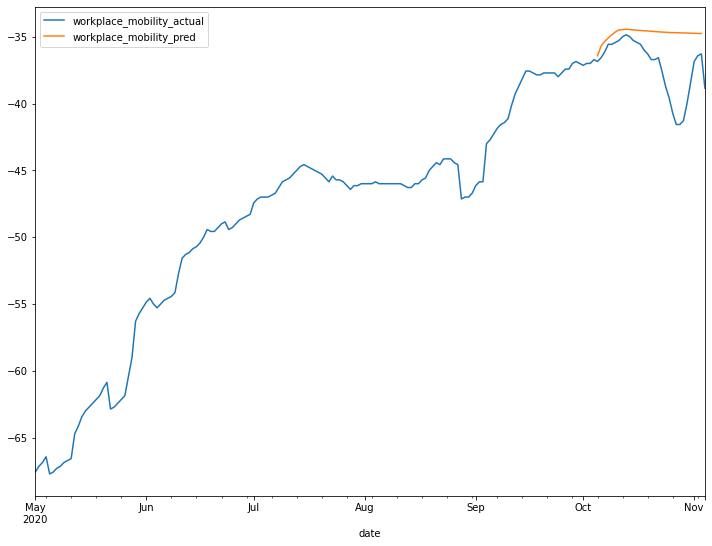

In [40]:
london_forecast = london_forecast[['workplaces_av_undiff','workplaces_av_pred_undiff']]
london_forecast.rename(columns = {'workplaces_av_undiff':'workplace_mobility_actual','workplaces_av_pred_undiff':'workplace_mobility_pred'}, inplace = True)
london_forecast.plot()

# True data in blue
# Forecast in orange

In [41]:
# Metrics:
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

true_mob = london_forecast['workplace_mobility_actual'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)] # -1 days required as final element is NaN
pred_mob = london_forecast['workplace_mobility_pred'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]

MAE_mob = metrics.mean_absolute_error(true_mob, pred_mob)
MSE_mob = metrics.mean_squared_error(true_mob, pred_mob)
MAPE_mob = metrics.mean_absolute_percentage_error(true_mob, pred_mob)

print(f"MAE: {np.round(MAE_mob,3)}")
print(f"MSE: {np.round(MSE_mob,3)}")
print(f"MAPE: {np.round(MAPE_mob,4)*100}%")

MAE: 2.425
MSE: 10.249
MAPE: 6.25%


## Prevalence

In [42]:
prev_london = prev[prev['region']=='LONDON']
prev_london = prev_london[['p']]
prev_london.rename(columns = {'p':'p_undiff'},inplace= True)
prev_london=pd.concat([prev_london, data_prev], axis=1)

In [43]:
prev_forecast = prev_london.loc[start_date:forecast_end_date]

In [44]:
# Cumulative sum three times as differenced three times
prev_forecast['undiff1_cum_sum'] = prev_forecast['p_pred'].cumsum()
prev_forecast['undiff2_cum_sum'] = prev_forecast['undiff1_cum_sum'].cumsum()
prev_forecast['undiff3_cum_sum'] = prev_forecast['undiff2_cum_sum'].cumsum()

/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/3313644190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['undiff1_cum_sum'] = prev_forecast['p_pred'].cumsum()
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/3313644190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['undiff2_cum_sum'] = prev_forecast['undiff1_cum_sum'].cumsum()
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/3313644190.py:4: SettingWithCopyWarning: 
A va

In [45]:
prev_forecast['p_pred_undiff']=np.nan
prev_forecast['p_pred_undiff'].loc[end_date] = prev_forecast['p_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]
prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]

for i in range(1,forecast_steps,1):
    prev_forecast['p_pred_undiff'].loc[end_date+relativedelta(days=i)]=prev_forecast['p_pred_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=i+1)]

    
prev_forecast.tail(31)  

/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/2692868598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['p_pred_undiff']=np.nan
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/2692868598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['p_pred_undiff'].loc[end_date] = prev_forecast['p_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/2692868598.py:6: SettingWithCopyWarning: 
A value is t

p_undiff         p        p_pred  undiff1_cum_sum  \
2020-10-05 -5.201207  0.000008           NaN              NaN   
2020-10-06 -5.186708       NaN  5.053720e-05         0.000051   
2020-10-07 -5.168119       NaN  1.231998e-04         0.000174   
2020-10-08 -5.146090       NaN -6.185226e-05         0.000112   
2020-10-09 -5.119855       NaN -1.149568e-04        -0.000003   
2020-10-10 -5.089902       NaN -1.131177e-04        -0.000116   
2020-10-11 -5.056828       NaN  1.313469e-05        -0.000103   
2020-10-12 -5.021691       NaN -1.581618e-04        -0.000261   
2020-10-13 -4.983789       NaN -4.783739e-05        -0.000309   
2020-10-14 -4.944657       NaN -5.272376e-05        -0.000362   
2020-10-15 -4.902953       NaN -4.043838e-05        -0.000402   
2020-10-16 -4.859807       NaN -7.715157e-05        -0.000479   
2020-10-17 -4.815396       NaN  3.067413e-05        -0.000449   
2020-10-18 -4.769586       NaN -3.021181e-05        -0.000479   
2020-10-19 -4.724690       NaN  8.826517e-06        -0.000470   
2020-10-20 -4.682052       NaN -1.398209e-06        -0.000471   
2020-10-21 -4.644984       NaN  1.603717e-05        -0.000455   
2020-10-22 -4.614563       NaN -5.954223e-06        -0.000461   
2020-10-23 -4.591608       NaN  8.373791e-06        -0.000453   
2020-10-24 -4.576812       NaN -2.687308e-06        -0.000456   
2020-10-25 -4.569616       NaN  8.888321e-06        -0.000447   
2020-10-26 -4.569066       NaN -5.348506e-06        -0.000452   
2020-10-27 -4.574546       NaN  6.917639e-06        -0.000445   
2020-10-28 -4.584696       NaN  6.334346e-07        -0.000445   
2020-10-29 -4.598362       NaN  1.858320e-06        -0.000443   
2020-10-30 -4.614294       NaN -2.675450e-06        -0.000445   
2020-10-31 -4.632053       NaN  3.170843e-06        -0.000442   
2020-11-01 -4.651339       NaN -4.832018e-06        -0.000447   
2020-11-02 -4.670796       NaN  5.147583e-07        -0.000447   
2020-11-03 -4.690178       NaN -2.584561e-06        -0.000449   
2020-11-04 -4.708521       NaN  8.558138e-08        -0.000449   

            undiff2_cum_sum  undiff3_cum_sum  p_pred_undiff  
2020-10-05              NaN              NaN      -5.201156  
2020-10-06         0.000051         0.000051      -5.200881  
2020-10-07         0.000224         0.000275      -5.200545  
2020-10-08         0.000336         0.000611      -5.200212  
2020-10-09         0.000333         0.000944      -5.199995  
2020-10-10         0.000217         0.001161      -5.199881  
2020-10-11         0.000114         0.001275      -5.200029  
2020-10-12        -0.000147         0.001127      -5.200485  
2020-10-13        -0.000456         0.000671      -5.201303  
2020-10-14        -0.000818        -0.000147      -5.202524  
2020-10-15        -0.001220        -0.001368      -5.204224  
2020-10-16        -0.001700        -0.003067      -5.206372  
2020-10-17        -0.002148        -0.005216      -5.209000  
2020-10-18        -0.002627        -0.007843      -5.212097  
2020-10-19        -0.003097        -0.010941      -5.215666  
2020-10-20        -0.003569        -0.014510      -5.219690  
2020-10-21        -0.004024        -0.018534      -5.224176  
2020-10-22        -0.004486        -0.023020      -5.229115  
2020-10-23        -0.004939        -0.027959      -5.234509  
2020-10-24        -0.005395        -0.033353      -5.240351  
2020-10-25        -0.005841        -0.039195      -5.246644  
2020-10-26        -0.006293        -0.045488      -5.253383  
2020-10-27        -0.006739        -0.052227      -5.260566  
2020-10-28        -0.007183        -0.059410      -5.268193  
2020-10-29        -0.007626        -0.067036      -5.276264  
2020-10-30        -0.008072        -0.075108      -5.284778  
2020-10-31        -0.008514        -0.083622      -5.293739  
2020-11-01        -0.008961        -0.092583      -5.303146  
2020-11-02        -0.009407        -0.101990      -5.313003  
2020-11-03        -0.009857        -0.111847      -5.323309  
2020-11-0

/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_49158/3731272891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast.rename(columns = {'p_undiff':'prevalence_actual','p_pred_undiff':'prevalence_pred'}, inplace = True)


<AxesSubplot:>

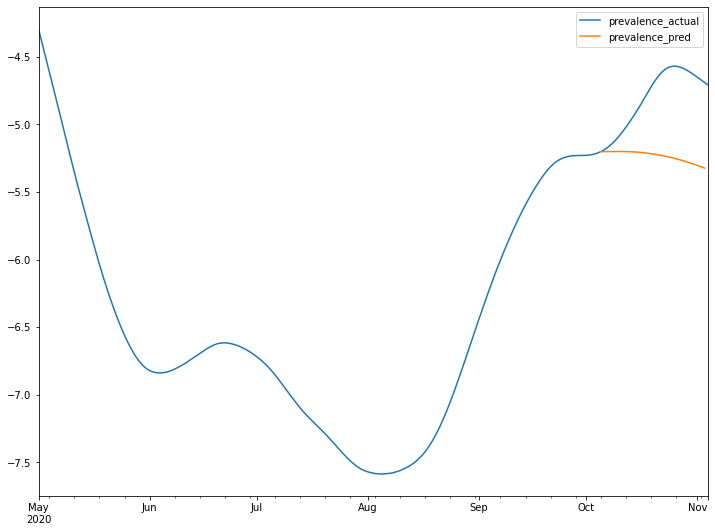

In [46]:
prev_forecast = prev_forecast[['p_undiff','p_pred_undiff']]
prev_forecast.rename(columns = {'p_undiff':'prevalence_actual','p_pred_undiff':'prevalence_pred'}, inplace = True)
prev_forecast.plot()

In [47]:
# Metrics

true_prev = prev_forecast['prevalence_actual'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]
pred_prev = prev_forecast['prevalence_pred'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]

MAE_prev = metrics.mean_absolute_error(true_prev, pred_prev)
MSE_prev = metrics.mean_squared_error(true_prev, pred_prev)
MAPE_prev = metrics.mean_absolute_percentage_error(true_prev, pred_prev)

print(f"MAE: {np.round(MAE_prev,3)}")
print(f"MSE: {np.round(MSE_prev,3)}")
print(f"MAPE: {np.round(MAPE_prev,4)*100}%")

MAE: 0.44
MSE: 0.252
MAPE: 9.42%


In [48]:
# Saving all useful stats from the run

stats =[shift_lag,forecast_steps,log_prevalence,ADF_mob_t,ADF_mob_p,ADF_prev_t,ADF_prev_p,KPSS_mob_stat,KPSS_mob_p,KPSS_prev_stat,KPSS_prev_p,lag_order,lag_order_BIC,
        lag_order_FPE,lag_order_HQIC,resid_corr_mob,resid_corr_prev,johansen_eigenvalue_mob,johansen_trace_mob,johansen_eigenvalue_prev,johansen_trace_prev,johansen_eignvalue_95_mob,
        johansen_eignvalue_95_prev,johansen_trace_95_mob,johansen_trace_95_prev,granger_p_mob_prev,granger_p_prev_mob,MAE_mob,MSE_mob,MAPE_mob,MAE_prev,MSE_prev,MAPE_prev]



stats_colnames = ['shift_lag','forecast_steps','log_prevalence','ADF_mob_t','ADF_mob_p','ADF_prev_t','ADF_prev_p','KPSS_mob_stat','KPSS_mob_p','KPSS_prev_stat','KPSS_prev_p','lag_order','lag_order_BIC','lag_order_FPE','lag_order_HQIC','resid_corr_mob','resid_corr_prev','johansen_eigenvalue_mob','johansen_trace_mob','johansen_eigenvalue_prev','johansen_trace_prev','johansen_eignvalue_95_mob','johansen_eignvalue_95_prev','johansen_trace_95_mob','johansen_trace_95_prev','granger_p_mob_prev','granger_p_prev_mob','MAE_mob','MSE_mob','MAPE_mob','MAE_prev','MSE_prev','MAPE_prev']

In [49]:
stats = pd.DataFrame (stats, stats_colnames)
stats

0
shift_lag                         -49
forecast_steps                     30
log_prevalence                   True
ADF_mob_t                   -3.822357
ADF_mob_p                    0.002687
ADF_prev_t                  -4.871892
ADF_prev_p                    0.00004
KPSS_mob_stat                0.256103
KPSS_mob_p                        0.1
KPSS_prev_stat               0.069329
KPSS_prev_p                       0.1
lag_order                           8
lag_order_BIC                       4
lag_order_FPE                       8
lag_order_HQIC                      6
resid_corr_mob               1.958653
resid_corr_prev              1.901442
johansen_eigenvalue_mob     50.496918
johansen_trace_mob          56.039915
johansen_eigenvalue_prev     5.542998
johansen_trace_prev          5.542998
johansen_eignvalue_95_mob     14.2639
johansen_eignvalue_95_prev     3.8415
johansen_trace_95_mob         15.4943
johansen_trace_95_prev         3.8415
granger_p_mob_prev             0.0519
granger_p_prev_mob             0.0623
MAE_mob                      2.425185
MSE_mob                     10.249139
MAPE_mob                     0.062506
MAE_prev                     0.440312
MSE_prev                     0.251619
MAPE_prev                    0.094157